In [1]:
import numpy as np
import itertools
import warnings
import matplotlib.pyplot as plt
from random import choice
import scipy.sparse as sparse

import tenpy
from tenpy.networks.site import Site, SpinHalfFermionSite, SpinHalfSite, GroupedSite, SpinSite
from tenpy.tools.misc import to_iterable, to_iterable_of_len, inverse_permutation
from tenpy.networks.mps import MPS  # only to check boundary conditions

from tenpy.models.lattice import Lattice, _parse_sites
from tenpy.models.model import CouplingMPOModel, NearestNeighborModel
from tenpy.tools.params import get_parameter

from tenpy.algorithms import dmrg
# from tenpy.networks import SpinHalfSite

# some api for the file operation
import h5py
from tenpy.tools import hdf5_io
import os.path

# functools
from functools import wraps

# path
from pathlib import Path

__all__ = ['KitaevLadder', 'KitaevLadderModel']


class KitaevLadderSnakeCompact(Lattice):    
    """ A ladder coupling two chains of the Kitaev form
    .. image :: /images/lattices/Ladder.*
    Parameters
    ----------
    L : int
        The length of each chain, we have 2*L sites in total.
    sites : (list of) :class:`~tenpy.networks.site.Site`
        The two local lattice sites making the `unit_cell` of the :class:`Lattice`.
        If only a single :class:`~tenpy.networks.site.Site` is given, it is used for both chains.
    **kwargs :
        Additional keyword arguments given to the :class:`Lattice`.
        `basis`, `pos` and `pairs` are set accordingly.
    """
    dim = 1

    def __init__(self, L, sites, **kwargs):
        sites = _parse_sites(sites, 2)
        basis = np.array([[2., 0.]])
        pos = np.array([[0., 0.], [1., 0.]])
        kwargs.setdefault('basis', basis)
        kwargs.setdefault('positions', pos)
        
        NNx = [(0, 1, np.array([0]))]
        NNy = [(1, 0, np.array([1]))]
        NNz = [(0, 1, np.array([1]))]
#         nNNa = [(1, 2, np.array([0])), (3, 0, np.array([1]))]
#         nNNb = [(0, 3, np.array([0])), (2, 1, np.array([1]))]
        
        kwargs.setdefault('pairs', {})
        kwargs['pairs'].setdefault('nearest_neighbors_x', NNx)
        kwargs['pairs'].setdefault('nearest_neighbors_y', NNy)
        kwargs['pairs'].setdefault('nearest_neighbors_z', NNz)
#         kwargs['pairs'].setdefault('next_nearest_neighbors_a', nNNa)
#         kwargs['pairs'].setdefault('next_nearest_neighbors_b', nNNb)

        kwargs.setdefault('bc', 'open')
        
        Lattice.__init__(self, [L], sites, **kwargs)
        
        
class KitaevLadderSnakeCompactModel(CouplingMPOModel):
    def __init__(self, model_params):
        CouplingMPOModel.__init__(self, model_params)

    def init_sites(self, model_params):
        # conserve = get_parameter(model_params, 'conserve', None, self.name)
        conserve = model_params.get('conserve', None)
        S = model_params.get('S', 0.5)
        fs = SpinHalfSite(conserve=conserve)
        return [fs, fs]

    def init_lattice(self, model_params):
        # L = get_parameter(model_params, 'L', 3, self.name)
        L = model_params.get('L', 3)

        gs = self.init_sites(model_params)
        model_params.pop("L")


        order = model_params.get('order', 'default')
        bc = model_params.get('bc', 'open')
        bc_MPS=model_params.get('bc_MPS', 'finite')
        lattice_params = dict(
            order=order,
            bc=bc,
            bc_MPS=bc_MPS,
            basis=None,
            positions=None,
            nearest_neighbors=None,
            next_nearest_neighbors=None,
            next_next_nearest_neighbors=None,
            pairs={},
        )

        lat = KitaevLadderSnakeCompact(L, gs, **lattice_params)
        return lat

    def init_terms(self, model_params):
        # Jx = get_parameter(model_params, 'Jx', 1., self.name, True)
        # Jy = get_parameter(model_params, 'Jy', 1., self.name, True)
        # Jz = get_parameter(model_params, 'Jz', 1., self.name, True)
        Jx = model_params.get('Jx', 1.)
        Jy = model_params.get('Jy', 1.)
        Jz = model_params.get('Jz', 1.)

        for u1, u2, dx in self.lat.pairs['nearest_neighbors_x']:
            self.add_coupling(Jx, u1, 'Sigmax', u2, 'Sigmax', dx)
        for u1, u2, dx in self.lat.pairs['nearest_neighbors_y']:
            self.add_coupling(Jy, u1, 'Sigmay', u2, 'Sigmay', dx)         
        for u1, u2, dx in self.lat.pairs['nearest_neighbors_z']:
            self.add_coupling(Jz, u1, 'Sigmaz', u2, 'Sigmaz', dx)
        
def plot_lattice():
    fig, ax = plt.subplots()
    lat = KitaevLadderSnakeCompact(5, None, bc='open')
    links_name = 'nearest_neighbors_z'
    lat.plot_coupling(ax, lat.pairs[links_name], linewidth=5.)
    # print(lat.pairs['nearest_neighbors'])
    print(lat.unit_cell)
    lat.plot_order(ax=ax, linestyle='--')
    lat.plot_sites(ax)
    # lat.plot_basis(ax, color='g', linewidth=3.)
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    # plt.title(links_name)
    plt.show()


In [3]:
def run_atomic(
    # model parameters
    chi=30,
    Jx=1., 
    Jy=1., 
    Jz=0., 
    L=4, 
    bc='periodic',
    bc_MPS='infinite',
    # dmrg parameters
    initial_psi=None, # input psi
    initial='random',
    max_E_err=1.e-6,
    max_S_err=1.e-4,
    max_sweeps=200,
    N_sweeps_check=10,
    canonicalized=True,
    # for extracting the low-lying states
    orthogonal_to=[],
    # control for the verbose output
    verbose=1, 
):
    """ 
        The fundamental function for running DMRG
    """

    #######################
    # set the paramters for model initialization
    model_params = dict(
        conserve=None, 
        Jx=Jx, 
        Jy=Jy, 
        Jz=Jz, 
        L=L, 
        verbose=verbose,
        bc=bc,
        bc_MPS=bc_MPS,
        )
    # initialize the model
    M = KitaevLadderSnakeCompactModel(model_params)
    # providing a product state as the initial state
    # prod_state = ["up", "up"] * (2 * model_params['L'])
    # random generated initial state
    if initial_psi==None:
        prod_state = [ choice(["up", "down"]) for i in range(2 * L)]
        if initial == 'up':
            prod_state = ["up" for i in range(2 * L)]
        if initial == 'down':
            prod_state = ["down" for i in range(2 * L)]
        psi = MPS.from_product_state(
            M.lat.mps_sites(), 
            prod_state, 
            bc=M.lat.bc_MPS,
        )
    else:
        psi = initial_psi.copy()
    #######################

    
    #######################
    # set the parameters for the dmrg routine
    dmrg_params = {
        'start_env': 10,
#         'mixer': False,  # setting this to True helps to escape local minima
        'mixer': True,
        'mixer_params': {
            'amplitude': 1.e-4,
            'decay': 1.2,
            'disable_after': 50
        },
        'trunc_params': {
            'chi_max': 4,
            'svd_min': 1.e-10,
        },
        'max_E_err': max_E_err,
        'max_S_err': max_S_err,
        'max_sweeps': max_sweeps,
        'N_sweeps_check': N_sweeps_check,
        'verbose': verbose,
        'orthogonal_to':orthogonal_to,
    }
    #######################
    
    if verbose:
        print("\n")
        print("=" * 80)
        print("="*30 + "START" + "="*30)
        print("=" * 80)
        print("Chi = ", chi, '\n')

    eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
    eng.reset_stats()
    eng.trunc_params['chi_max'] = chi
    info = eng.run()

    if canonicalized:
        psi.canonical_form()
        if verbose:
            print("Before the canonicalization:")
            print("Bond dim = ", psi.chi)

            print("Canonicalizing...")
            psi_before = psi.copy()


        if verbose:
            ov = psi.overlap(psi_before, charge_sector=0)
            print("The norm is: ",psi.norm)
            print("The overlap is: ", ov)
            print("After the canonicalization:")
            print("Bond dim = ", psi.chi)

        print("Computing properties")

    energy=info[0]

    if verbose:
        print("Optimizing")

    tenpy.tools.optimization.optimize(3)

    if verbose:
        print("Loop for chi=%d done." % chi)
        print("=" * 80)
        print("="*30 + " END " + "="*30)
        print("=" * 80)
        
    # the wave function, the ground-state energy, and the DMRG engine are all that we need
    result = dict(
        psi=psi.copy(),
        energy=energy,
        sweeps_stat=eng.sweep_stats.copy(),
        parameters=dict(
            # model parameters
            chi=chi,
            Jx=Jx, 
            Jy=Jy, 
            Jz=Jz, 
            L=L, 
            # dmrg parameters
            initial_psi=initial_psi,
            initial=initial,
            max_E_err=max_E_err,
            max_S_err=max_S_err,
            max_sweeps=max_sweeps,
        )
    )
    return result

def naming(
    # model parameters
    chi=30,
    Jx=1., 
    Jy=1., 
    Jz=0., 
    L=3, 
    ):
    return "KitaevLadder"+"_chi_"+str(chi)+"_Jx_"+str(Jx)+"_Jy_"+str(Jy)+"_Jz_"+str(Jz)+"_L_"+str(L)

def full_path(
    # model parameters
    chi=30,
    Jx=1., 
    Jy=1., 
    Jz=0., 
    L=3, 
    prefix='data/', suffix='.h5',
    **kwargs):
    return prefix+naming(chi, Jx, Jy, Jz, L)+suffix
    
def save_after_run(run, folder_prefix='data/'):
    """
        Save data as .h5 files
    """
    @wraps(run)
    def wrapper(*args, **kwargs):
        # if there is no such folder, create another one; if exists, doesn't matter
        Path(folder_prefix).mkdir(parents=True, exist_ok=True)
        file_name = full_path(prefix=folder_prefix, **kwargs)
        
        # if the file already existed then don't do the computation again
        if os.path.isfile(file_name):
            print("This file already existed. Pass.")
            return 0
        else:
            result = run(*args, **kwargs)
            with h5py.File(file_name, 'w') as f:
                hdf5_io.save_to_hdf5(f, result)
                
            return result
    
    return wrapper

def load_data(
    chi=30,
    Jx=1., 
    Jy=1., 
    Jz=0., 
    L=3, 
    prefix='data/', 
):
    file_name = full_path(chi, Jx, Jy, Jz, L, prefix=prefix, suffix='.h5')
    if not Path(file_name).exists():
        return -1
    with h5py.File(file_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)
        return data

def finite_scaling(
    # model params, should be input
    Jx = 0.5,
    Jy = 0.5,
    Jz = 0,
    L = 3,

    # next there are some DMRG params
    # tolerance for entropy calc error, should be input
    max_S_err = 1e-4,
    N_sweeps_check = 5,
    max_sweeps = 1000,

    # bond dimension list, should be input
    chi_list = range(8, 50, 2),
    
    # initial wave function
    psi = None,

    verbose = 1,
    
    # should we load the existing files and also save the results into files
    save_and_load = False,
    
    # should we do plotting after calculation
    plot = False,
):
    """
        Computing the finite-scaling cases at a specific `J=(Jx, Jy, Jz)`, over a specific bond dimension region.
    """
    
    if save_and_load:
        # folder name
        prefix = f'data_L_{L}_comb/'
        # if there is no such folder, create another one; if exists, doesn't matter
        Path(prefix).mkdir(parents=True, exist_ok=True)
        run_save = save_after_run(run_atomic, folder_prefix=prefix)


    S_list = []
    xi_list = []

    psi = psi
    
    for chi in chi_list:
        
        if save_and_load:
            data = run_save(
                Jx = Jx,
                Jy = Jy,
                Jz = Jz,
                L = L,
                max_S_err=max_S_err,
                chi = chi,
                initial_psi=psi,
                N_sweeps_check=N_sweeps_check,    
                max_sweeps=max_sweeps, 
                verbose=verbose,
            )

            if data==0:
                data = load_data(Jx = Jx, Jy = Jy, Jz = Jz, L = L, chi = chi, prefix = prefix)
                pass
            pass
        else:
            data = run_atomic(
                Jx = Jx,
                Jy = Jy,
                Jz = Jz,
                L = L,
                max_S_err=max_S_err,
                chi = chi,
                initial_psi=psi,
                N_sweeps_check=N_sweeps_check,    
                max_sweeps=max_sweeps, 
                verbose=verbose,
            )
            pass
        
        psi = data['psi']
        S_list.append(np.mean(psi.entanglement_entropy()))
        xi_list.append(psi.correlation_length())        
        pass
    
    if plot:
        start = 0
        end = -1

        xs = np.log(xi_list[start:end])
        ys = S_list[start:end]

        def func(log_xi, c, a):
            return (c / 6) * log_xi + a
        fitParams, fitCovariances = curve_fit(func, xs, ys)

        plt.plot(xs, ys, 'o', label='Data Points')
        plt.xlabel(r'Log of Correlation Length, $\log\xi$')
        plt.ylabel(r'Average Entanglement Entropy, $S$')

        fitting_label = r'Curve Fitting: $S = \frac{c}{6}\log\xi + b$, c = %.2f, b= %.2f' % (fitParams[0], fitParams[1])
        plt.plot(xs, func(xs, fitParams[0], fitParams[1]), label=fitting_label)

        plt.legend()
        title_name = f'Finite Scaling at J = ({Jx}, {Jy}, {Jz}), L={L}'
        plt.title(title_name)

        plt.show()
        plt.savefig(title_name + '.png')
        pass
    return S_list, xi_list

def fDMRG_KL(
    Jx=1., 
    Jy=1., 
    Jz=1., 
    L=3, 
    chi=100, 
    verbose=True, 
    order='default', 
    bc_MPS='finite', 
    bc='open',
    # to extract the low-lying excitation
    orthogonal_to={}, 
    ):
    """
        The finite DMRG for Kitaev Ladders
    """
    
    print("finite DMRG, Kitaev ladder model")
    print("L = {L:d}, Jx = {Jx:.2f}, Jy = {Jy:.2f}, Jz = {Jz:.2f}, ".format(L=L, Jx=Jx, Jy=Jy, Jz=Jz))
    model_params = dict(L=L, Jx=Jx, Jy=Jy, Jz=Jz, bc_MPS=bc_MPS, bc=bc, conserve=None, order=order, verbose=verbose)
    M = KitaevLadderSnakeCompactModel(model_params)
    
    print("bc_MPS = ", M.lat.bc_MPS)
    
    product_state = [np.random.choice(["up", "down"]) for i in range(M.lat.N_sites)]
    psi = MPS.from_product_state(M.lat.mps_sites(), product_state, bc=M.lat.bc_MPS)
    dmrg_params = {
#         'mixer': None,  # setting this to True helps to escape local minima
        'mixer': True,
        'mixer_params': {
            'amplitude': 1.e-4,
            'decay': 1.2,
            'disable_after': 50
        },
        'max_E_err': 1.e-10,
        'trunc_params': {
            'chi_max': chi,
            'svd_min': 1.e-10
        },
        'verbose': verbose,
        'combine': True,
        'orthogonal_to': orthogonal_to,
    }
    info = dmrg.run(psi, M, dmrg_params)  # the main work...
    E = info['E']
    print("E = {E:.13f}".format(E=E))
    print("final bond dimensions: ", psi.chi) 

    return E, psi, M

In [6]:
Jx=1
Jy=1
Jz=1

# Loop control
max_trials = 4
max_E_err = 1e-10

# Stored data
orthogonal_to = []
energy = []

for i in range(max_trials):
#     if i > 1: # there are already 2 or more energies
#         if energy[i-1] - energy[i-2] > max_E_err:
#             break
    
    E, psi, M = fDMRG_KL(Jx=Jx, Jy=Jy, Jz=Jz, L=6, chi=20, orthogonal_to=orthogonal_to, bc='open')
    energy.append(E)
    orthogonal_to.append(psi.copy())
    
    pass

print("Energy list : ", energy)

finite DMRG, Kitaev ladder model
L = 6, Jx = 1.00, Jy = 1.00, Jz = 1.00, 
Reading 'L'=6 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'order'='default' for config KitaevLadderSnakeCompactModel
Reading 'bc'='open' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='finite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=1 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1 for config KitaevLadderSnakeCompactModel
bc_MPS =  finite
Reading 'combine'=True for config DMRG
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config DMRG
Reading 'orthogonal_to'=[] for config DMRG
Reading 'max_E_err'=1e-10 for config DMRG
Reading 'mixer'=True for config DMRG
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config DMRG
sweep 10, age = 12
Energy = -9.5076081499294798, S = nan, norm_err = 1.1e-08
Current memory usage 147.4 MB, tim

KeyboardInterrupt: 

In [21]:
for e in energy:
    print(e*4)

-9.50760814996505
-9.507608149965057
-9.156244038380752
-9.156244038380732
-8.926662824176159
-8.926659675340833
-9.15624380375187
-9.156244038380649
-9.060957257895922
-9.06095722938223


In [44]:
Jx=1
Jy=1
Jz=1

L=200

# Loop control
max_trials = 4
max_E_err = 1e-10

# Stored data
orthogonal_to = []
energy = []

for i in range(max_trials):
    
    E, psi, M = fDMRG_KL(Jx=Jx, Jy=Jy, Jz=Jz, L=L, chi=60, orthogonal_to=orthogonal_to, bc='periodic')
    energy.append(E)
    orthogonal_to.append(psi.copy())
    
    pass

print("Energy list : ", energy)

finite DMRG, Kitaev ladder model
L = 200, Jx = 1.00, Jy = 1.00, Jz = 1.00, 
Reading 'L'=200 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'order'='default' for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='finite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=1 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1 for config KitaevLadderSnakeCompactModel
bc_MPS =  finite
Reading 'combine'=True for config DMRG
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config DMRG
Reading 'orthogonal_to'=[] for config DMRG
Reading 'max_E_err'=1e-10 for config DMRG
Reading 'mixer'=True for config DMRG
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config DMRG
sweep 10, age = 400
Energy = -335.5217549556134031, S = nan, norm_err = 1.0e-05
Current memory usage 13

sweep 50, age = 400
Energy = -335.5217560310499607, S = 1.5276738447834286, norm_err = 6.9e-06
Current memory usage 1388.2 MB, time elapsed: 1082.2 s
Delta E = -9.7697e-09, Delta S = 2.3334e-07 (per sweep)
max_trunc_err = 5.9205e-08, max_E_trunc = 7.9133e-07
MPS bond dimensions: [2, 4, 8, 8, 16, 16, 32, 32, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60,

sweep 30, age = 400
Energy = -335.5217560821608345, S = nan, norm_err = 6.1e-06
Current memory usage 1388.2 MB, time elapsed: 820.8 s
Delta E = -4.6776e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2750e-07, max_E_trunc = 8.4390e-07
MPS bond dimensions: [2, 4, 8, 13, 18, 24, 41, 51, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60

bc_MPS =  finite
Reading 'combine'=True for config DMRG
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config DMRG
Reading 'orthogonal_to'=[<tenpy.networks.mps.MPS object at 0x7f4824c09d10>, <tenpy.networks.mps.MPS object at 0x7f47db0d3410>] for config DMRG
Reading 'max_E_err'=1e-10 for config DMRG
Reading 'mixer'=True for config DMRG
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config DMRG
sweep 10, age = 400
Energy = -334.7056202685938615, S = nan, norm_err = 2.3e-04
Current memory usage 1388.2 MB, time elapsed: 430.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.5071e-07, max_E_trunc = 2.2405e-06
MPS bond dimensions: [2, 4, 8, 16, 32, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60

sweep 50, age = 400
Energy = -334.7063210391297616, S = 1.5412824790991297, norm_err = 5.8e-06
Current memory usage 1388.2 MB, time elapsed: 1287.5 s
Delta E = 1.1056e-08, Delta S = 9.9843e-08 (per sweep)
max_trunc_err = 9.9016e-08, max_E_trunc = 1.2373e-06
MPS bond dimensions: [2, 4, 8, 8, 16, 32, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 

Convergence criterium reached with enabled mixer.
disable mixer and continue
sweep 30, age = 400
Energy = -334.8469970691791104, S = 1.5332898810101465, norm_err = 4.9e-03
Current memory usage 1388.2 MB, time elapsed: 1034.9 s
Delta E = -6.5224e-05, Delta S = nan (per sweep)
max_trunc_err = 1.0214e-07, max_E_trunc = 1.2541e-06
MPS bond dimensions: [2, 4, 8, 8, 16, 24, 32, 34, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 6

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


DMRG finished after 50 sweeps.
total size = 400, maximum chi = 60
E = -334.8469726769895
final bond dimensions:  [2, 4, 8, 8, 16, 16, 32, 32, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60

In [42]:
finite_scaling(Jx=1, Jy=1, Jz=1, L=120, chi_list=[2**n for n in range(3,8)])

Reading 'L'=120 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=1 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  8 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=5 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)


Before the canonicalization:
Bond dim =  [4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.11322844952294672+5.445405411308446e-17j)
After the canonicalization:
Bond dim =  [4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['P_tol'] for config lanczos_params

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:287: UserWarning: Correlation length: largest eigenvalue not one. Not in canonical form/normalized?


Reading 'L'=120 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=1 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  16 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=5 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(

KeyboardInterrupt: 

## Exact Diagonalization

Now we will implement the ED

In [30]:
# get single site operaors
sx = sparse.csr_matrix(np.array([[0., 1.], [1., 0.]]))
sy = sparse.csc_matrix(np.array([[0., -1.0j], [1.0j, 0.]]))
sz = sparse.csr_matrix(np.array([[1., 0.], [0., -1.]]))
id = sparse.csr_matrix(np.eye(2))
sigma_list = [id, sx, sy, sz]

def Sigma(op_num, site, L=12):
    assert op_num==0 or op_num==1 or op_num==2 or op_num==3
    assert site>=0 and site<L
    
    op = sigma_list[op_num]
    
    if site==0:
        return sparse.kron(op, sparse.csr_matrix(np.eye(2**(L-1))))
    elif site==L-1:
        return sparse.kron(sparse.csr_matrix(np.eye(2**(L-1))), op)
    else: 
        IA = sparse.kron(sparse.csr_matrix(np.eye(2**(site))), op)
        return sparse.kron(IA, sparse.csr_matrix(np.eye(2**(L-1-site))))
    
def Splus(site, L=12):
    assert site>=0 and site<L
    
    sx = Sigma(1, site, L=L)
    sy = Sigma(2, site, L=L)
    
    return 0.5 * (sx + 1j * sy)

def Sminus(site, L=12):
    return Splus(site, L=L).conjugate().transpose()
    

In [61]:
def get_H_Kitaev_Ladder2(Jx=1, Jy=1, Jz=1, unit_number=6, bc='open'):
    # parameter setting
    unit_size = 2
    L = unit_number * unit_size

    H_xx = sparse.csr_matrix((2**L, 2**L))
    for i in range(unit_number):
        site1 = 2*i
        site2 = site1 + 1

        op_num = 1 # 1 represents x

    #     print("i = ", i)
        X1 = Sigma(op_num, site1, L=L)
        X2 = Sigma(op_num, site2, L=L)
        H_xx += X1.dot(X2)

        pass

    H_yy = sparse.csr_matrix((2**L, 2**L))
    for i in range(unit_number - 1):
        site1 = 2*i + 1
        site2 = site1+1

        op_num = 2
        Y1 = Sigma(op_num, site1, L=L)
        Y2 = Sigma(op_num, site2, L=L)
        H_yy += Y1.dot(Y2)

        pass
    
    H_zz = sparse.csr_matrix((2**L, 2**L))
    for i in range(unit_number - 1):
        site1 = 2*i
        site2 = site1 + 3

        op_num = 3
        Z1 = Sigma(op_num, site1, L=L)
        Z2 = Sigma(op_num, site2, L=L)
        H_zz += Z1.dot(Z2)

        pass

    if bc=='periodic':
#         raise NotImplementedError('The ED for PBC not implemented!!!\n')
        
        # add the Y term crossing the boundary
        site1 = L - 1
        site2 = 0
        
        op_num = 2
        Y1 = Sigma(op_num, site1, L=L)
        Y2 = Sigma(op_num, site2, L=L)
        H_yy += Y1.dot(Y2)
        
        # add the Z term crossing the boundary
        site1 = L - 2
        site2 = 1
        
        op_num = 3
        Z1 = Sigma(op_num, site1, L=L)
        Z2 = Sigma(op_num, site2, L=L)
        H_zz += Z1.dot(Z2)
        pass

    H = Jx * H_xx + Jy * H_yy + Jz * H_zz
    
    return H

def prod_Sz_before_site(site, L=12):
    assert site>=0 and site<L
    if site == 0:
        return sparse.csr_matrix(np.eye(2**L))
    prod = sz
    if site > 1:
        for i in range(site-1):
            prod = sparse.kron(prod, sz)
            pass
    rest_L = L - site
    rest = sparse.csr_matrix(np.eye(2**rest_L))
    return sparse.kron(prod, rest)
    
def creator(site, L=12):
    Sp = Splus(site, L=L)
    prodSz = prod_Sz_before_site(site, L=L)
    return Sp.dot(prodSz)
    
def annihilator(site, L=12):
    return creator(site, L=L).conjugate().transpose()

def number(site, L=12):
    return creator(site,L=L).dot(annihilator(site,L=L))

def eta_a(site, L=12):
    fp = creator(site, L=L)
    fm = annihilator(site, L=L)
    if site % 2 == 0: # for the first, third, fifth, ...
        return 1j * (fp - fm)
    else:
        return fp + fm
    pass

def eta_b(site, L=12):
    fp = creator(site, L=L)
    fm = annihilator(site, L=L)
    if site % 2 == 1: # for the second, fourth, sixth, ...
        return 1j * (fp - fm)
    else:
        return fp + fm
    pass

def get_D(i, L=12, bc='open'):
    if bc=='open':
        assert 2*i + 3 < L
    elif bc=='periodic':
        assert i < L//2
    assert i >= 0
    eta1 = eta_b(2*i, L=L)
    eta2 = eta_b((2*i+3) % L, L=L)
    if i==L//2 - 1: # the boundary term
        return -1j * eta1.dot(eta2)
    return 1j * eta1.dot(eta2)

## Periodic Ladder with 2 unit-cells

The unit number of the snake will be 4

`J=(1,1,1)`

### The ground state spectrum

In [39]:
def epsilon(k, Jx=1, Jy=1, Jz=1):
    coef=np.abs(Jx)
    abs_Jy = np.abs(Jy)
    abs_Jz = np.abs(Jz)
    sgn_Jy = Jy / abs_Jy
    sgn_Jz = Jz / abs_Jz
    
    cos_term = 1 + sgn_Jy * (abs_Jy - abs_Jz) * np.cos(k)
    sin_term = (abs_Jy + abs_Jz) * np.sin(k)
    return coef * np.sqrt(cos_term**2 + sin_term**2)

def epsilon_D(k, Jx=1, Jy=1, Jz=1, D=1):
    coef=np.abs(Jx)
    abs_Jy = np.abs(Jy)
    abs_Jz = np.abs(Jz)
    sgn_Jy = Jy / abs_Jy
    sgn_Jz = Jz / abs_Jz
    
    cos_term = 1 + sgn_Jy * (abs_Jy - abs_Jz) * np.cos(k)
    sin_term = (abs_Jy + abs_Jz) * np.sin(k)
    return coef * np.sqrt(cos_term**2 + sin_term**2)

def k_list_at_N(N, bc='antiperiodic'):
    if bc=='periodic':
        return [ -np.pi + n * 2 * np.pi / N for n in range(N)]
    if bc=='antiperiodic':
        return [ -np.pi + (np.pi/N) + (n * 2 * np.pi / N) for n in range(N)]
    raise Exception("Boundary condition not supported!")

def get_eps_list(Jx=1, Jy=1, Jz=1, unit_number=6, bc='antiperiodic'):
    return [epsilon(k, Jx=Jx,Jy=Jy,Jz=Jz) for k in k_list_at_N(unit_number, bc=bc)]
    
def get_E(Jx=1, Jy=1, Jz=1, unit_number=6, bc='antiperiodic'):
    epsilon_list = [epsilon(k, Jx=Jx,Jy=Jy,Jz=Jz) for k in k_list_at_N(unit_number, bc=bc)]
    return np.sum(epsilon_list)

Using Elliptic Integral to show that the `cos` spectrum is never ground

$$\epsilon(k) = \pm\sqrt{(J_x^\prime + (J_y^\prime + D J_z^\prime)\cos k)^2 + (J_y^\prime - D J_z^\prime)^2\sin^2k}.$$

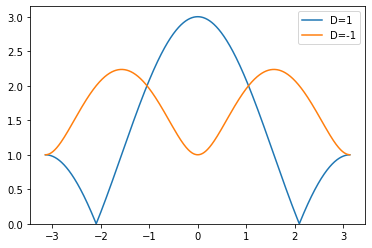

Jx=1, Jy=1, Jz=1, D=1, Calculating with quad integrate, the energy is:  -9.022598332668833
Jx=1, Jy=1, Jz=1, D=-1, Calculating with quad integrate, the energy is:  -10.54073432638252
Ep - Em = 1.5181359937136865
Analytic: -1.5181359937138161


In [5]:
from scipy.special import ellipe
import scipy.integrate as integrate

def test_func(k, J):
    return np.sqrt(1+J**2 * np.sin(k)**2)
# ellipe(-2)

def gs_k(Jy, Jz):
    assert Jy>=0 and Jz>=0
    Jp = Jy + Jz
    return 4 * ellipe(-(Jp)**2)

def es_k(Jy, Jz):
    assert Jy>=0 and Jz>=0
    assert Jy==Jz
    Jp = Jy+Jz
    k0 = np.arccos(-1./Jp)
    sink0 = np.sqrt(Jp**2 - 1) / Jp
    return 2*(2*k0 - np.pi + 2*Jp*sink0)

def diff(Jy, Jz):
    return gs_k(Jy, Jz) - es_k(Jy, Jz)

def ek(k, Jx, Jy, Jz, D):
    assert Jx>=0 and Jy>=0 and Jz>=0
    assert D==1 or D==-1
    Jp = Jy + D * Jz
    Jm = Jy - D * Jz
    Hp = Jx + Jp * np.cos(k)
    Hm = Jm * np.sin(k)
    return np.sqrt(Hp**2 + Hm**2)

# test the ellipe function
J = 1

N_k=10
k_list = [np.pi * n / (2 * N_k) for n in range(N_k)]
f_list = [test_func(k, J) for k in k_list]
np.sum(f_list) * np.pi / (2 * N_k) - ellipe(-J**2)

# calculate the difference between two spectra
Jy = 2
Jz = 2

diff(Jy, Jz)

# plot the two branches for D=1 and D=-1
Jx = 1
Jy = 1
Jz = 1

N_k = 1000
k_list = [-np.pi + 2 * np.pi * n / N_k for n in range(N_k)]
ekp_list = [ek(k, Jx, Jy, Jz, 1) for k in k_list]
ekm_list = [ek(k, Jx, Jy, Jz, -1) for k in k_list]
plt.plot(k_list, ekp_list, label=f'D=1')
plt.plot(k_list, ekm_list, label=f'D=-1')
plt.legend()
plt.ylim(bottom = 0)
plt.show()

# Jx = 1
# Jy = 1
# Jz = 0
ekp_func = lambda k:ek(k, Jx, Jy, Jz, 1)
ekm_func = lambda k:ek(k, Jx, Jy, Jz, -1)

Ep = integrate.quad(ekp_func, -np.pi, np.pi)
Em = integrate.quad(ekm_func, -np.pi, np.pi)

print(f'Jx={Jx}, Jy={Jy}, Jz={Jz}, D=1, Calculating with quad integrate, the energy is: ', -Ep[0])
print(f'Jx={Jx}, Jy={Jy}, Jz={Jz}, D=-1, Calculating with quad integrate, the energy is: ', -Em[0])

print(f'Ep - Em = { - Ep[0] + Em[0]}')
print(f'Analytic: {-diff(Jy, Jz)}')

In [4]:
Jx=1
Jy=1
Jz=1

# Loop control
max_trials = 4
max_E_err = 1e-10

# Stored data
orthogonal_to = []
energy = []

for i in range(max_trials):
#     if i > 1: # there are already 2 or more energies
#         if energy[i-1] - energy[i-2] > max_E_err:
#             break
    
    data = run_atomic(Jx=Jx, Jy=Jy, Jz=Jz, L=2, chi=30, orthogonal_to=orthogonal_to)
    energy.append(data['energy'])
    psi = data['psi']
    orthogonal_to.append(psi.copy())
    
    pass

print("Energy list : ", energy)

Reading 'L'=2 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=1 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  30 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'orthogonal_to'=[] for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for con

ValueError: Can't orthogonalize for infinite MPS: overlap not well defined.

OK.

There is no proper overlap for infinite MPS.

A more generic proof

In [142]:
def e_k_sorted(k, Jx, Jy, Jz, D):
    Jp = Jy + D*Jz
    J2 = Jx**2 + Jy**2 + Jz**2
    return np.sqrt(J2 + 2 * Jx * Jp * np.cos(k) + 2 * D * Jy * Jz * np.cos(2*k))

def E_sorted(Jx, Jy, Jz, D):
    assert D==1 or D==-1
    e_k_D_sorted_func = lambda k:e_k_sorted(k, Jx, Jy, Jz, D)
    return integrate.quad(e_k_D_sorted_func, -np.pi, np.pi)[0] * -1

def E_true(Jx, Jy, Jz):
    D_true = 1 if Jy*Jz < 0 else -1
    E_true = E_sorted(Jx, Jy, Jz, D_true)
    return E_true
    
E_true(1, 1, 1) / (-0.8388049849220067 * 4 * np.pi)
    
# E_true(1, -.8,-2.0) / -1.1222456021128409

# region = np.arange(-2, 2, .1)
# for Jx in region:
#     for Jy in region:
#         for Jz in region:
            
#             D_true = 1 if Jy*Jz < 0 else -1
#             D_false = D_true*-1
#             E_true = E_sorted(Jx, Jy, Jz, D_true)
#             E_false = E_sorted(Jx, Jy, Jz, D_false)
# #             print(f"Jx={Jx}, Jy={Jy}, Jz={Jz}:\n D={D_true}, E={E_true} \n D={D_false}, E={E_false}\n")
#             if E_true >= E_false and np.abs(Jy) > 1e-8 and np.abs(Jz) > 1e-8:
#                 print(f"Weird point here: Jx={Jx}, Jy={Jy}, Jz={Jz},")
#                 print(f"Jx={Jx}, Jy={Jy}, Jz={Jz}:\n D={D_true}, E={E_true} \n D={D_false}, E={E_false}\n")


1.0000000012030117

Perfect Match!

In [143]:
from kitaev_ladder_snake import load_data

In [152]:
prefix='snake/'

Jz = 1
Jx_list = [-2.0, -1.8, -1.6, -1.4, -1.2, -1.0, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
Jy_list = [-2.0, -1.8, -1.6, -1.4, -1.2, -1.0, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
L = 4
# chi_list = [16, 32, 64]
# chi_list = [64, 128]
chi = 128

for Jx in Jx_list:
    for Jy in Jy_list:
        result = load_data(
            chi=chi,
            Jx=Jz,
            Jy=Jx,
            Jz=Jy,
            L=L,
            prefix=prefix,
        )
        if result != -1:
            energy_DMRG = result['energy']
            energy_spectrum = E_true(Jz, Jx, Jy) / (4 * np.pi)
            error = ((energy_DMRG/energy_spectrum) - 1)
            if np.abs(error) > 1e-5:
                print(f'J = ({Jx}, {Jy}, {Jz}): Error: {error}.\n DMRG: {energy_DMRG}\n Spectra: {energy_spectrum}')
                pass 
            pass
        else:
            print(f"File for J = ({Jx}, {Jy}, {Jz}) not existing!")

# result = load_data(
#     chi=30,
#     Jx=1., 
#     Jy=1., 
#     Jz=0., 
#     L=4, 
#     prefix='data/', 
# )

File for J = (-0.6, 1.6, 1) not existing!
File for J = (-0.6, 1.8, 1) not existing!
File for J = (-0.6, 2.0, 1) not existing!
File for J = (-0.4, -2.0, 1) not existing!
File for J = (-0.4, -1.8, 1) not existing!
File for J = (-0.4, -1.6, 1) not existing!
File for J = (-0.4, -1.4, 1) not existing!
File for J = (-0.4, -1.2, 1) not existing!
File for J = (-0.4, -1.0, 1) not existing!
File for J = (-0.4, -0.8, 1) not existing!
File for J = (-0.4, -0.6, 1) not existing!
File for J = (-0.4, -0.4, 1) not existing!
File for J = (-0.4, -0.2, 1) not existing!
File for J = (-0.4, 0, 1) not existing!
File for J = (-0.4, 0.2, 1) not existing!
File for J = (-0.4, 0.4, 1) not existing!
File for J = (-0.4, 0.6, 1) not existing!
File for J = (-0.4, 0.8, 1) not existing!
File for J = (-0.4, 1.0, 1) not existing!
File for J = (-0.4, 1.2, 1) not existing!
File for J = (-0.4, 1.4, 1) not existing!
File for J = (-0.4, 1.6, 1) not existing!
File for J = (-0.4, 1.8, 1) not existing!
File for J = (-0.4, 2.0, 1

A figure for the analytical results.
Showing both $D=\pm 1$ to convince people that we have chosen correct local symmetries.

Firstly, a slice along the `Jy` line at `Jx=1`, `Jz=1`

In [185]:
Jz = 1
Jx = 1
Jy_list = np.arange(-3, 3, .01)
E_p_list = [E_sorted(Jz, Jx, Jy, D=1) / (4 * np.pi) for Jy in Jy_list]
E_m_list = [E_sorted(Jz, Jx, Jy, D=-1) / (4 * np.pi) for Jy in Jy_list]

In [186]:
Jz = 1
Jx = 1.0
L=4
chi=64
prefix='snake/'
Jy_list = [-2.0, -1.8, -1.6, -1.4, -1.2, -1.0, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
E_dmrg_list = []
for Jy in Jy_list:
    data = load_data(
        chi=chi,
        Jx=Jz,
        Jy=Jx,
        Jz=Jy,
        L=L,
        prefix=prefix,
    )
    E_dmrg_list.append(data['energy'])

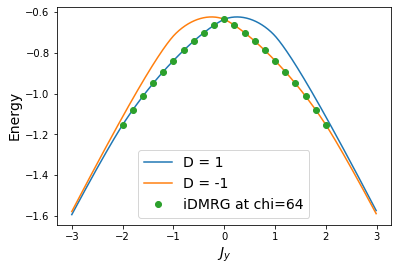

In [187]:
Jy_list = np.arange(-3, 3, .01)
plt.plot(Jy_list, E_p_list, label='D = 1')
plt.plot(Jy_list, E_m_list, label='D = -1')
Jy_list = [-2.0, -1.8, -1.6, -1.4, -1.2, -1.0, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
plt.plot(Jy_list, E_dmrg_list, 'o', label=f'iDMRG at chi={chi}')
fontsize = 14
plt.xlabel(r'$J_y$', fontsize=fontsize)
plt.ylabel('Energy', fontsize=fontsize)
plt.legend(fontsize=fontsize)
# plt.title('Jx=%.1f, Jz=%.1f' % (Jx, Jz))
plt.savefig(f'E_slice_Jx_{Jx}_Jz_{Jz}.png')
plt.show()

A slice along the `Jy` line at `Jx=0.4`, `Jz=1`

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  if __name__ == '__main__':


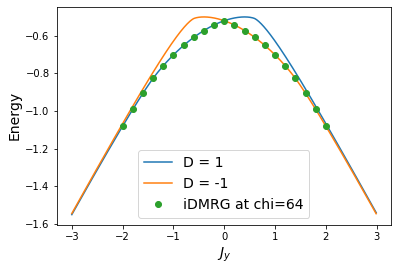

In [183]:
Jz = 1
Jx = 0.4
Jy_list = np.arange(-3, 3, .01)
E_p_list = [E_sorted(Jz, Jx, Jy, D=1) / (4 * np.pi) for Jy in Jy_list]
E_m_list = [E_sorted(Jz, Jx, Jy, D=-1) / (4 * np.pi) for Jy in Jy_list]

plt.plot(Jy_list, E_p_list, label='D = 1')
plt.plot(Jy_list, E_m_list, label='D = -1')
Jy_list = [-2.0, -1.8, -1.6, -1.4, -1.2, -1.0, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]

L=4
chi=64
prefix='snake/'
E_dmrg_list = []
for Jy in Jy_list:
    data = load_data(
        chi=chi,
        Jx=Jz,
        Jy=Jx,
        Jz=Jy,
        L=L,
        prefix=prefix,
    )
    E_dmrg_list.append(data['energy'])
plt.plot(Jy_list, E_dmrg_list, 'o', label=f'iDMRG at chi={chi}')
fontsize = 14
plt.xlabel(r'$J_y$', fontsize=fontsize)
plt.ylabel('Energy', fontsize=fontsize)
plt.legend(fontsize=fontsize)
# plt.title('Jx=%.1f, Jz=%.1f' % (Jx, Jz))
plt.savefig(f'E_slice_Jx_{Jx}_Jz_{Jz}.png')
plt.show()

Jx = 1.6

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  if __name__ == '__main__':


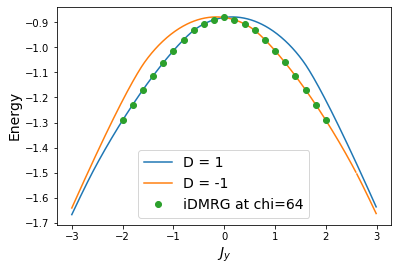

In [182]:
Jz = 1
Jx = 1.6
Jy_list = np.arange(-3, 3, .01)
E_p_list = [E_sorted(Jz, Jx, Jy, D=1) / (4 * np.pi) for Jy in Jy_list]
E_m_list = [E_sorted(Jz, Jx, Jy, D=-1) / (4 * np.pi) for Jy in Jy_list]

plt.plot(Jy_list, E_p_list, label='D = 1')
plt.plot(Jy_list, E_m_list, label='D = -1')
Jy_list = [-2.0, -1.8, -1.6, -1.4, -1.2, -1.0, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]

L=4
chi=64
prefix='snake/'
E_dmrg_list = []
for Jy in Jy_list:
    data = load_data(
        chi=chi,
        Jx=Jz,
        Jy=Jx,
        Jz=Jy,
        L=L,
        prefix=prefix,
    )
    E_dmrg_list.append(data['energy'])
plt.plot(Jy_list, E_dmrg_list, 'o', label=f'iDMRG at chi={chi}')
fontsize = 14
plt.xlabel(r'$J_y$', fontsize=fontsize)
plt.ylabel('Energy', fontsize=fontsize)
plt.legend(fontsize=fontsize)
# plt.title('Jx=%.1f, Jz=%.1f' % (Jx, Jz))
plt.savefig(f'E_slice_Jx_{Jx}_Jz_{Jz}.png')
plt.show()

Extreme case

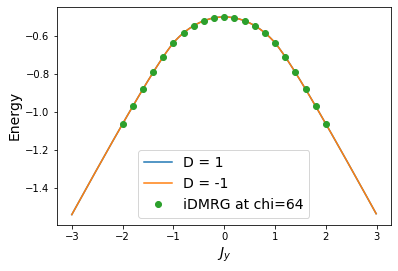

In [179]:
Jz = 1
Jx = 0
Jy_list = np.arange(-3, 3, .01)
E_p_list = [E_sorted(Jz, Jx, Jy, D=1) / (4 * np.pi) for Jy in Jy_list]
E_m_list = [E_sorted(Jz, Jx, Jy, D=-1) / (4 * np.pi) for Jy in Jy_list]

plt.plot(Jy_list, E_p_list, label='D = 1')
plt.plot(Jy_list, E_m_list, label='D = -1')
Jy_list = [-2.0, -1.8, -1.6, -1.4, -1.2, -1.0, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]

L=4
chi=64
prefix='snake/'
E_dmrg_list = []
for Jy in Jy_list:
    data = load_data(
        chi=chi,
        Jx=Jz,
        Jy=Jx,
        Jz=Jy,
        L=L,
        prefix=prefix,
    )
    E_dmrg_list.append(data['energy'])
plt.plot(Jy_list, E_dmrg_list, 'o', label=f'iDMRG at chi={chi}')
fontsize = 14
plt.xlabel(r'$J_y$', fontsize=fontsize)
plt.ylabel('Energy', fontsize=fontsize)
plt.legend(fontsize=fontsize)
# plt.title('Jx=%.1f, Jz=%.1f' % (Jx, Jz))
plt.savefig(f'E_slice_Jx_{Jx}_Jz_{Jz}.png')
plt.show()

In [ ]:
Jy_list = np.arange(-3, 3, .01)
plt.plot(Jy_list, E_p_list, label='D = 1')
plt.plot(Jy_list, E_m_list, label='D = -1')
Jy_list = [-2.0, -1.8, -1.6, -1.4, -1.2, -1.0, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
plt.plot(Jy_list, E_dmrg_list, 'o', label=f'iDMRG at chi={chi}')
plt.xlabel('Jy')
plt.ylabel('Energy')
plt.legend()
plt.title('Jx=%.1f, Jz=%.1f' % (Jx, Jz))
plt.savefig(f'E_slice_Jx_{Jx}_Jz_{Jz}.png')
plt.show()

In [139]:
run_atomic(Jx=1, Jy=1, Jz=1, L=4)

Reading 'L'=4 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=1 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  30 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4

{'psi': <tenpy.networks.mps.MPS at 0x7effaa7a80d0>,
 'energy': -0.8388049849220067,
 'sweeps_stat': {'sweep': [10, 20, 30, 40],
  'N_updates': [240, 480, 720, 960],
  'E': [-0.8388049821162031,
   -0.8388049840611842,
   -0.838804984925595,
   -0.8388049849220067],
  'S': [nan, nan, 1.2232331174089075, 1.223233121971],
  'time': [11.1316397190094,
   16.99715542793274,
   21.035484552383423,
   24.904348850250244],
  'max_trunc_err': [7.906862628680355e-10,
   4.4762047739039816e-10,
   1.5676403343986133e-10,
   1.5717186064587604e-10],
  'max_E_trunc': [3.2061961974250153e-09,
   2.368096829741262e-09,
   1.7582806322025135e-09,
   1.774424163158983e-09],
  'max_chi': [30, 30, 30, 30],
  'norm_err': [1.5148646236440282e-09,
   2.0068853965862033e-09,
   3.038761222772913e-15,
   2.7432229843205232e-15]},
 'parameters': {'chi': 30,
  'Jx': 1,
  'Jy': 1,
  'Jz': 1,
  'L': 4,
  'initial_psi': None,
  'initial': 'random',
  'max_E_err': 1e-06,
  'max_S_err': 0.0001,
  'max_sweeps': 200}}

In [32]:
H = get_H_Kitaev_Ladder2(unit_number=4, bc='periodic').toarray()

In [33]:
E, V = np.linalg.eigh(H)

In [34]:
print(E)

[-6.92820323e+00 -6.47213595e+00 -6.47213595e+00 -6.47213595e+00
 -5.80642385e+00 -5.80642385e+00 -5.80642385e+00 -5.80642385e+00
 -5.80642385e+00 -5.80642385e+00 -5.80642385e+00 -5.80642385e+00
 -5.80642385e+00 -5.80642385e+00 -5.80642385e+00 -5.80642385e+00
 -5.65685425e+00 -5.65685425e+00 -5.65685425e+00 -5.46410162e+00
 -5.46410162e+00 -5.46410162e+00 -5.46410162e+00 -5.46410162e+00
 -5.46410162e+00 -5.46410162e+00 -5.46410162e+00 -5.46410162e+00
 -5.46410162e+00 -5.46410162e+00 -5.46410162e+00 -4.00000000e+00
 -4.00000000e+00 -4.00000000e+00 -4.00000000e+00 -4.00000000e+00
 -4.00000000e+00 -3.41855072e+00 -3.41855072e+00 -3.41855072e+00
 -3.41855072e+00 -3.41855072e+00 -3.41855072e+00 -3.41855072e+00
 -3.41855072e+00 -3.41855072e+00 -3.41855072e+00 -3.41855072e+00
 -3.41855072e+00 -2.82842712e+00 -2.82842712e+00 -2.82842712e+00
 -2.82842712e+00 -2.82842712e+00 -2.82842712e+00 -2.82842712e+00
 -2.82842712e+00 -2.82842712e+00 -2.82842712e+00 -2.82842712e+00
 -2.82842712e+00 -2.82842

Analytic values

In [76]:
get_E(unit_number=4, bc='antiperiodic')

6.92820323027551

In [75]:
get_E(unit_number=4, bc='periodic')

6.47213595499958

In [80]:
2*(2*np.sqrt(3))

6.928203230275509

In [81]:
2*(1+np.sqrt(5))

6.47213595499958

DMRG values

In [78]:
E, psi, M = fDMRG_KL(L=4, bc='periodic', bc_MPS='finite')

finite DMRG, Kitaev ladder model
L = 4, Jx = 1.00, Jy = 1.00, Jz = 1.00, 
Reading 'L'=4 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'order'='default' for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='finite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.0 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=1.0 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel
bc_MPS =  finite
Reading 'combine'=True for config DMRG
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config DMRG
Reading 'orthogonal_to'={} for config DMRG
Reading 'max_E_err'=1e-10 for config DMRG
Reading 'mixer'=True for config DMRG
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config DMRG
sweep 10, age = 8
Energy = -6.9282032302755043, S = nan, norm_err = 1.4e-14
Current memory usage 214.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['P_tol'] for config lanczos_params

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


In [79]:
E, psi, M = fDMRG_KL(L=4, bc='periodic', bc_MPS='finite', orthogonal_to=[psi])

finite DMRG, Kitaev ladder model
L = 4, Jx = 1.00, Jy = 1.00, Jz = 1.00, 
Reading 'L'=4 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'order'='default' for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='finite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.0 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=1.0 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel
bc_MPS =  finite
Reading 'combine'=True for config DMRG
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config DMRG
Reading 'orthogonal_to'=[<tenpy.networks.mps.MPS object at 0x7effc9dbf290>] for config DMRG
Reading 'max_E_err'=1e-10 for config DMRG
Reading 'mixer'=True for config DMRG
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config DMRG
sweep 10, age = 8
Energy = -6.4721359549995787, S = 

sweep 210, age = 8
Energy = -6.4721359549995805, S = 1.2254094731464709, norm_err = 1.0e+00
Current memory usage 221.4 MB, time elapsed: 59.8 s
Delta E = -5.3291e-16, Delta S = 2.2472e-02 (per sweep)
max_trunc_err = 1.3994e-27, max_E_trunc = 5.3291e-15
MPS bond dimensions: [2, 4, 8, 16, 8, 4, 2]
sweep 220, age = 8
Energy = -6.4721359548767454, S = 1.2307003493078306, norm_err = 4.2e-01
Current memory usage 221.4 MB, time elapsed: 62.3 s
Delta E = 1.2284e-11, Delta S = 5.2909e-04 (per sweep)
max_trunc_err = 1.7891e-28, max_E_trunc = 6.2172e-15
MPS bond dimensions: [2, 4, 8, 16, 8, 4, 2]
sweep 230, age = 8
Energy = -6.4721359549995823, S = 1.1719876708241852, norm_err = 8.8e-01
Current memory usage 221.4 MB, time elapsed: 65.0 s
Delta E = -1.2284e-11, Delta S = -5.8713e-03 (per sweep)
max_trunc_err = 0.0000e+00, max_E_trunc = 6.2172e-15
MPS bond dimensions: [2, 4, 8, 16, 8, 4, 2]
sweep 240, age = 8
Energy = -6.4721359549995769, S = 1.0829483866497986, norm_err = 7.7e-01
Current memory us

sweep 430, age = 8
Energy = -6.4721359549995885, S = 1.1363350990393137, norm_err = 1.2e+00
Current memory usage 221.4 MB, time elapsed: 118.5 s
Delta E = -7.1054e-16, Delta S = 9.0685e-03 (per sweep)
max_trunc_err = 0.0000e+00, max_E_trunc = 1.0658e-14
MPS bond dimensions: [2, 4, 8, 16, 8, 4, 2]
sweep 440, age = 8
Energy = -6.4721358438477434, S = 1.3704704061563724, norm_err = 1.9e-01
Current memory usage 221.4 MB, time elapsed: 120.9 s
Delta E = 1.1115e-08, Delta S = 2.3414e-02 (per sweep)
max_trunc_err = 8.2604e-25, max_E_trunc = 3.5527e-15
MPS bond dimensions: [2, 4, 8, 16, 8, 4, 2]
sweep 450, age = 8
Energy = -6.4721359549995832, S = 1.1195363434977341, norm_err = 7.5e-01
Current memory usage 221.4 MB, time elapsed: 123.4 s
Delta E = -1.1115e-08, Delta S = -2.5093e-02 (per sweep)
max_trunc_err = 0.0000e+00, max_E_trunc = 2.6645e-15
MPS bond dimensions: [2, 4, 8, 16, 8, 4, 2]
sweep 460, age = 8
Energy = -6.4721359549995805, S = 1.2444512366986091, norm_err = 5.6e-01
Current memory

sweep 650, age = 8
Energy = -6.4721359549995885, S = 1.3267244356373149, norm_err = 7.0e-01
Current memory usage 221.4 MB, time elapsed: 172.3 s
Delta E = -6.2172e-16, Delta S = 3.2315e-02 (per sweep)
max_trunc_err = 1.9475e-24, max_E_trunc = 6.2172e-15
MPS bond dimensions: [2, 4, 8, 16, 8, 4, 2]
sweep 660, age = 8
Energy = -6.4721359549995841, S = 1.1556349478201562, norm_err = 1.2e+00
Current memory usage 221.4 MB, time elapsed: 174.6 s
Delta E = 4.4409e-16, Delta S = -1.7109e-02 (per sweep)
max_trunc_err = 2.1396e-23, max_E_trunc = 5.3291e-15
MPS bond dimensions: [2, 4, 8, 16, 8, 4, 2]
sweep 670, age = 8
Energy = -6.4721359549995805, S = 1.2247745805969470, norm_err = 4.1e-01
Current memory usage 221.4 MB, time elapsed: 176.9 s
Delta E = 3.5527e-16, Delta S = 6.9140e-03 (per sweep)
max_trunc_err = 8.1428e-24, max_E_trunc = 5.3291e-15
MPS bond dimensions: [2, 4, 8, 8, 8, 4, 2]
sweep 680, age = 8
Energy = -6.4721359549995796, S = 1.0037935923412677, norm_err = 1.2e+00
Current memory u

sweep 870, age = 8
Energy = -6.4721359549995787, S = 1.0068761728751379, norm_err = 3.1e-02
Current memory usage 222.1 MB, time elapsed: 229.5 s
Delta E = 6.2172e-16, Delta S = -2.3403e-02 (per sweep)
max_trunc_err = 2.5266e-24, max_E_trunc = 1.4211e-14
MPS bond dimensions: [2, 4, 8, 8, 8, 4, 2]
sweep 880, age = 8
Energy = -6.4721359549995805, S = 1.2390284511548528, norm_err = 9.9e-01
Current memory usage 222.1 MB, time elapsed: 232.0 s
Delta E = -1.7764e-16, Delta S = 2.3215e-02 (per sweep)
max_trunc_err = 0.0000e+00, max_E_trunc = 8.8818e-15
MPS bond dimensions: [2, 4, 8, 16, 8, 4, 2]
sweep 890, age = 8
Energy = -6.4721359549995778, S = 1.1116906946696663, norm_err = 7.6e-01
Current memory usage 222.1 MB, time elapsed: 234.4 s
Delta E = 2.6645e-16, Delta S = -1.2734e-02 (per sweep)
max_trunc_err = 0.0000e+00, max_E_trunc = 7.9936e-15
MPS bond dimensions: [2, 4, 8, 16, 8, 4, 2]
sweep 900, age = 8
Energy = -6.4721359549995823, S = 1.2035403899580257, norm_err = 8.6e-01
Current memory 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['P_tol'] for config lanczos_params

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


#### Check the flux configuration

In [63]:
N=4
D_list = [get_D(i, L=2*N, bc='periodic') for i in range(N)]
gs = V[:, 0]
for D in D_list:
    print(np.round(D @ gs @ gs))

(-1+0j)
(-1+0j)
(-1+0j)
(-1+0j)


In [72]:
N=4
D_list = [get_D(i, L=2*N, bc='periodic') for i in range(N)]
es1 = V[:, 1]
es2 = V[:, 2]
es3 = V[:, 3]
for D in D_list:
    print(np.round(D @ es1 @ es1, decimals=3))
    print(np.round(D @ es1 @ es2, decimals=3))
    print(np.round(D @ es1 @ es3, decimals=3))
    print('\n')
for D in D_list:
    print(np.round(D @ es2 @ es1, decimals=3))
    print(np.round(D @ es2 @ es2, decimals=3))
    print(np.round(D @ es2 @ es3, decimals=3))
    print('\n')
for D in D_list:
    print(np.round(D @ es3 @ es1, decimals=3))
    print(np.round(D @ es3 @ es2, decimals=3))
    print(np.round(D @ es3 @ es3, decimals=3))
    print('\n')

(-0.981+0j)
(0.137+0j)
(0.136+0j)


(-0.981+0j)
(-0.137+0j)
(0.136+0j)


(-0.981+0j)
(0.137+0j)
(0.136+0j)


(0.981+0j)
(-0.137+0j)
(-0.136+0j)


(0.137+0j)
0j
(0.991+0j)


(-0.137+0j)
(-0+0j)
(-0.991+0j)


(0.137+0j)
0j
(0.991+0j)


(-0.137+0j)
(-0+0j)
(-0.991+0j)


(0.136+0j)
(0.991+0j)
(-0.019+0j)


(0.136+0j)
(-0.991+0j)
(-0.019+0j)


(0.136+0j)
(0.991+0j)
(-0.019+0j)


(-0.136+0j)
(-0.991+0j)
(0.019+0j)




In [73]:
0.981**2 + 0.137**2 + 0.136**2

0.999626

In [38]:
N=4
# Jx = 1
# Jy = 1
# Jz = 2
get_E(unit_number=N, bc='antiperiodic')

6.92820323027551

In [51]:
6.92820323 - np.sqrt(3)

5.196152422431123

In [5]:
H = get_H_Kitaev_Ladder2(unit_number=6, bc='periodic')

In [6]:
H = H.toarray()

In [7]:
E, V = np.linalg.eigh(H)

In [8]:
E

array([-10.1289902 , -10.        ,  -9.52988641, ...,   9.52988641,
        10.        ,  10.1289902 ])

In [29]:
N=6
# Jx = 1
# Jy = 1
# Jz = 2
E(bc='periodic')

10.0

In [23]:
print((E - E[0])[:1000])

[0.         0.1289902  0.59910379 0.59910379 0.59910379 0.59910379
 0.59910379 0.59910379 0.87456419 0.87456419 0.87456419 0.87456419
 0.87456419 0.87456419 0.87456419 0.87456419 0.87456419 0.91092015
 0.91092015 0.91092015 0.91092015 0.91092015 0.91092015 0.91092015
 0.91092015 0.91092015 0.91092015 0.91092015 0.91092015 1.00588458
 1.00588458 1.00588458 1.00588458 1.00588458 1.00588458 1.00588458
 1.00588458 1.00588458 1.03049861 1.03049861 1.03049861 1.1676902
 1.1676902  1.1676902  1.1676902  1.1676902  1.1676902  1.20078697
 1.24275724 1.24275724 1.24275724 1.24275724 1.24275724 1.24275724
 1.24275724 1.24275724 1.24275724 1.24275724 1.24275724 1.24275724
 1.24275724 1.24275724 1.24275724 1.24275724 1.24275724 1.24275724
 1.24275724 1.24275724 1.24275724 1.24275724 1.24275724 1.24275724
 1.30056308 1.30056308 1.30056308 1.30056308 1.30056308 1.30056308
 1.30056308 1.30056308 1.30056308 1.30056308 1.30056308 1.30056308
 1.43063501 1.43063501 1.43063501 1.43063501 1.43063501 1.43063

In [17]:
v = V[:,0]
H @ v @ v

(-10.128990204491943+0j)

In [19]:
v = V[:,1]
H @ v @ v

(-9.999999999999986+0j)

In [16]:
D_list = [get_D(i, L=12, bc='periodic') for i in range(6)]

In [20]:
for D in D_list:
    print(D@v@v)

(-1.0000000000000022+0j)
(-1.0000000000000027+0j)
(-1.0000000000000022+0j)
(-1.0000000000000027+0j)
(-1.0000000000000027+0j)
(-1.0000000000000022+0j)


In [48]:
units=6
Jx=.01
Jy=1.1
Jz=1
L=2*units
H = get_H_Kitaev_Ladder2(Jx=Jx, Jy=Jy, Jz=Jz, unit_number=units, bc='periodic')
H = H.toarray()
E, V = np.linalg.eigh(H)
v = V[:,0]
D_list = [get_D(i, L=L, bc='periodic').toarray() for i in range(units)]
print("The D values for the ground states")
for D in D_list:
#     print(D.shape)
    print(D@v@v)
    
print("The D values for the highest states")
v = V[:,-1]
for D in D_list:
#     print(D.shape)
    print(D@v@v)
    


The D values for the ground states
(-1.0000000000000004+0j)
(-0.9999999999999996+0j)
(-0.9999999999999999+0j)
(-1+0j)
(-1+0j)
(0.9999999999999994+0j)
The D values for the highest states
(-0.9999999999999998+0j)
(-0.9999999999999997+0j)
(-1.0000000000000004+0j)
(-1.0000000000000007+0j)
(-1.0000000000000004+0j)
(1.0000000000000002+0j)


In [49]:
v = V[:,1]
for D in D_list:
#     print(D.shape)
    print(D@v@v)
    


(-0.8181895438430222+0j)
(-0.24256839106104172+0j)
(0.18610505182264891+0j)
(-0.3190487991010469+0j)
(0.10133886299850453+0j)
(0.907637180816045+0j)


In [50]:
E[:1000]

array([-8.41449766, -8.4143933 , -8.4143933 , -8.4143933 , -8.4143933 ,
       -8.4143933 , -8.4143933 , -8.4143723 , -8.4143723 , -8.4143723 ,
       -8.41433759, -8.41433759, -8.41433759, -8.41433759, -8.41433759,
       -8.41433759, -7.94602468, -7.94602468, -7.94602468, -7.94602468,
       -7.94602468, -7.94602468, -7.94595498, -7.94595498, -7.94595498,
       -7.94595498, -7.94595498, -7.94595498, -7.94595498, -7.94595498,
       -7.94595498, -7.94595498, -7.94595498, -7.94595498, -7.94595443,
       -7.94595443, -7.94595443, -7.94595443, -7.94595443, -7.94595443,
       -7.94588526, -7.94588526, -7.94587287, -7.94587287, -7.94587287,
       -7.94587287, -7.94587287, -7.94587287, -7.74606163, -7.74606163,
       -7.74606163, -7.74606163, -7.74606163, -7.74606163, -7.74597104,
       -7.74597104, -7.74597104, -7.74597104, -7.74597104, -7.74597104,
       -7.74596964, -7.74596964, -7.74596964, -7.74596964, -7.74596964,
       -7.74596964, -7.74596964, -7.74596964, -7.74596964, -7.74

In [72]:
units=6
L=2*units
H = get_H_Kitaev_Ladder2(unit_number=units, bc='open')
H = H.toarray()
E, V = np.linalg.eigh(H)
print(E)

[-9.50760815 -9.50760815 -9.15624404 ...  9.15624404  9.50760815
  9.50760815]


In [47]:
D_list = [get_D(i, L=8, bc='periodic').toarray() for i in range(units)]
for D in D_list:
    print(D.shape)

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


### JW Transformation

Jordan-Wigner transformation is capable of treating general 1D spin chain.

In [15]:
def prod_Sz_before_site(site, L=12):
    assert site>=0 and site<L
    if site == 0:
        return sparse.csr_matrix(np.eye(2**L))
    prod = sz
    if site > 1:
        for i in range(site-1):
            prod = sparse.kron(prod, sz)
            pass
    rest_L = L - site
    rest = sparse.csr_matrix(np.eye(2**rest_L))
    return sparse.kron(prod, rest)
    
def creator(site, L=12):
    Sp = Splus(site, L=L)
    prodSz = prod_Sz_before_site(site, L=L)
    return Sp.dot(prodSz)
    
def annihilator(site, L=12):
    return creator(site, L=L).conjugate().transpose()

def number(site, L=12):
    return creator(site,L=L).dot(annihilator(site,L=L))

def eta_a(site, L=12):
    fp = creator(site, L=L)
    fm = annihilator(site, L=L)
    if site % 2 == 0: # for the first, third, fifth, ...
        return 1j * (fp - fm)
    else:
        return fp + fm
    pass

def eta_b(site, L=12):
    fp = creator(site, L=L)
    fm = annihilator(site, L=L)
    if site % 2 == 1: # for the second, fourth, sixth, ...
        return 1j * (fp - fm)
    else:
        return fp + fm
    pass

def get_D(i, L=12, bc='open'):
    if bc=='open':
        assert 2*i + 3 < L
    elif bc=='periodic':
        assert i < L//2
    assert i >= 0
    eta1 = eta_b(2*i, L=L)
    eta2 = eta_b((2*i+3) % L, L=L)
    return 1j * eta1.dot(eta2)

Test the fermionic relation

In [87]:
fp = creator(0).toarray()
fm = annihilator(0).toarray()

result = fm @ fp + fp @ fm - np.eye(2**12)
print(result)
np.linalg.norm(result)

[[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]


0.0

In [89]:
fp = creator(1).toarray()
fm = annihilator(1).toarray()

result = fm @ fp + fp @ fm - np.eye(2**12)
print(result)
np.linalg.norm(result)

[[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]


0.0

In [90]:
fp = creator(2).toarray()
fm = annihilator(2).toarray()

result = fm @ fp + fp @ fm - np.eye(2**12)
print(result)
np.linalg.norm(result)

[[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]


0.0

In [91]:
fp = creator(1).toarray()
fm = annihilator(0).toarray()

result = fm @ fp + fp @ fm 
print(result)
np.linalg.norm(result)

[[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]


0.0

In [92]:
fp = creator(1).toarray()
fp = annihilator(6).toarray()

result = fm @ fp + fp @ fm
print(result)
np.linalg.norm(result)

[[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]


0.0

In [93]:
fm = creator(1).toarray()
fm = annihilator(6).toarray()

result = fm @ fp + fp @ fm
print(result)
np.linalg.norm(result)

[[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]


0.0

In [104]:
v0 = V[:,0]
v1 = V[:,1]

In [105]:
for i in range(5):
    print(f"The {i}th D:")
    D = get_D(i)
    print(D@v0@v0)
    print(D@v1@v1)
    print(D@v1@v0)
    print(D@v0@v1)

The 0th D:
(-0.9999999999999999+0j)
(-0.9999999999999997+0j)
(-4.093362511056743e-18+0j)
(-4.0933625110567614e-18+0j)
The 1th D:
(-0.9999999999999999+0j)
(-0.9999999999999996+0j)
(-4.0933625110570264e-18+0j)
(-4.0933625110569525e-18+0j)
The 2th D:
(-1+0j)
(-0.9999999999999996+0j)
(-4.093362511056669e-18+0j)
(-4.093362511056644e-18+0j)
The 3th D:
(-0.9999999999999999+0j)
(-0.9999999999999998+0j)
(-4.093362511057088e-18+0j)
(-4.093362511057113e-18+0j)
The 4th D:
(-0.9999999999999998+0j)
(-0.9999999999999996+0j)
(-4.093362511056595e-18+0j)
(-4.09336251105657e-18+0j)


In [106]:
Jx = 1
Jy = 1
Jz = -1
print(f'Kitaev Ladder in a compact snake order, Jx={Jx}, Jy={Jy}, Jz={Jz}')
H = get_H_Kitaev_Ladder2(Jx=Jx, Jy=Jy, Jz=Jz).toarray()
E, V = np.linalg.eigh(H)
v0 = V[:, 0]
v1 = V[:, 1]
for i in range(5):
    print(f"The {i}th D:")
    D = get_D(i)
    print("Applied on the eigenvectors, component with self")
    print(D@v0@v0)
    print(D@v1@v1)
    print("Applied on the eigenvectors, component with the other")
    print(D@v1@v0)
    print(D@v0@v1)

Kitaev Ladder in a compact snake order, Jx=1, Jy=1, Jz=-1
The 0th D:
Applied on the eigenvectors, component with self
(1+0j)
(1+0j)
Applied on the eigenvectors, component with the other
(-2.533441289579213e-17+0j)
(-2.5334412895792073e-17+0j)
The 1th D:
Applied on the eigenvectors, component with self
(1+0j)
(0.9999999999999999+0j)
Applied on the eigenvectors, component with the other
(-2.5334412895792986e-17+0j)
(-2.5334412895793066e-17+0j)
The 2th D:
Applied on the eigenvectors, component with self
(0.9999999999999998+0j)
(1+0j)
Applied on the eigenvectors, component with the other
(-2.5334412895791747e-17+0j)
(-2.5334412895791713e-17+0j)
The 3th D:
Applied on the eigenvectors, component with self
(1+0j)
(1+0j)
Applied on the eigenvectors, component with the other
(-2.5334412895792403e-17+0j)
(-2.5334412895792375e-17+0j)
The 4th D:
Applied on the eigenvectors, component with self
(0.9999999999999998+0j)
(1+0j)
Applied on the eigenvectors, component with the other
(-2.5334412895792628

In [107]:
Jx = 1
Jy = -1
Jz = 1
print(f'Kitaev Ladder in a compact snake order, Jx={Jx}, Jy={Jy}, Jz={Jz}')
H = get_H_Kitaev_Ladder2(Jx=Jx, Jy=Jy, Jz=Jz).toarray()
E, V = np.linalg.eigh(H)
v0 = V[:, 0]
v1 = V[:, 1]
for i in range(5):
    print(f"The {i}th D:")
    D = get_D(i)
    print("Applied on the eigenvectors, component with self")
    print(D@v0@v0)
    print(D@v1@v1)
    print("Applied on the eigenvectors, component with the other")
    print(D@v1@v0)
    print(D@v0@v1)

Kitaev Ladder in a compact snake order, Jx=1, Jy=-1, Jz=1
The 0th D:
Applied on the eigenvectors, component with self
(0.9999999999999999+0j)
(0.9999999999999997+0j)
Applied on the eigenvectors, component with the other
(-4.093362511056743e-18+0j)
(-4.0933625110567614e-18+0j)
The 1th D:
Applied on the eigenvectors, component with self
(0.9999999999999999+0j)
(0.9999999999999996+0j)
Applied on the eigenvectors, component with the other
(-4.0933625110570264e-18+0j)
(-4.0933625110569525e-18+0j)
The 2th D:
Applied on the eigenvectors, component with self
(1+0j)
(0.9999999999999996+0j)
Applied on the eigenvectors, component with the other
(-4.093362511056669e-18+0j)
(-4.093362511056644e-18+0j)
The 3th D:
Applied on the eigenvectors, component with self
(0.9999999999999999+0j)
(0.9999999999999998+0j)
Applied on the eigenvectors, component with the other
(-4.093362511057088e-18+0j)
(-4.093362511057113e-18+0j)
The 4th D:
Applied on the eigenvectors, component with self
(0.9999999999999998+0j)


In [112]:
Jx = 1
Jy = -1
Jz = -1
print(f'Kitaev Ladder in a compact snake order, Jx={Jx}, Jy={Jy}, Jz={Jz}')
H = get_H_Kitaev_Ladder2(Jx=Jx, Jy=Jy, Jz=Jz).toarray()
E, V = np.linalg.eigh(H)
v0 = V[:, 0]
v1 = V[:, 1]
for i in range(5):
    print(f"The {i}th D:")
    D = get_D(i)
    print("Applied on the eigenvectors, component with self")
    print(D@v0@v0)
    print(D@v1@v1)
    print("Applied on the eigenvectors, component with the other")
    print(D@v1@v0)
    print(D@v0@v1)

Kitaev Ladder in a compact snake order, Jx=1, Jy=-1, Jz=-1
The 0th D:
Applied on the eigenvectors, component with self
(-1+0j)
(-1+0j)
Applied on the eigenvectors, component with the other
(2.533441289579213e-17+0j)
(2.5334412895792073e-17+0j)
The 1th D:
Applied on the eigenvectors, component with self
(-1+0j)
(-0.9999999999999999+0j)
Applied on the eigenvectors, component with the other
(2.5334412895792986e-17+0j)
(2.5334412895793066e-17+0j)
The 2th D:
Applied on the eigenvectors, component with self
(-0.9999999999999998+0j)
(-1+0j)
Applied on the eigenvectors, component with the other
(2.5334412895791747e-17+0j)
(2.5334412895791713e-17+0j)
The 3th D:
Applied on the eigenvectors, component with self
(-1+0j)
(-1+0j)
Applied on the eigenvectors, component with the other
(2.5334412895792403e-17+0j)
(2.5334412895792375e-17+0j)
The 4th D:
Applied on the eigenvectors, component with self
(-0.9999999999999998+0j)
(-1+0j)
Applied on the eigenvectors, component with the other
(2.53344128957926

In [108]:
Jx = -1
Jy = 1
Jz = 1
print(f'Kitaev Ladder in a compact snake order, Jx={Jx}, Jy={Jy}, Jz={Jz}')
H = get_H_Kitaev_Ladder2(Jx=Jx, Jy=Jy, Jz=Jz).toarray()
E, V = np.linalg.eigh(H)
v0 = V[:, 0]
v1 = V[:, 1]
for i in range(5):
    print(f"The {i}th D:")
    D = get_D(i)
    print("Applied on the eigenvectors, component with self")
    print(D@v0@v0)
    print(D@v1@v1)
    print("Applied on the eigenvectors, component with the other")
    print(D@v1@v0)
    print(D@v0@v1)

Kitaev Ladder in a compact snake order, Jx=-1, Jy=1, Jz=1
The 0th D:
Applied on the eigenvectors, component with self
(-1.0000000000000009+0j)
(-0.9999999999999991+0j)
Applied on the eigenvectors, component with the other
(2.3389783828110133e-18+0j)
(2.338978382811081e-18+0j)
The 1th D:
Applied on the eigenvectors, component with self
(-1.0000000000000004+0j)
(-0.9999999999999991+0j)
Applied on the eigenvectors, component with the other
(2.338978382811944e-18+0j)
(2.3389783828120056e-18+0j)
The 2th D:
Applied on the eigenvectors, component with self
(-1.0000000000000004+0j)
(-0.9999999999999989+0j)
Applied on the eigenvectors, component with the other
(2.3389783828107483e-18+0j)
(2.33897838281089e-18+0j)
The 3th D:
Applied on the eigenvectors, component with self
(-1.0000000000000007+0j)
(-0.9999999999999989+0j)
Applied on the eigenvectors, component with the other
(2.3389783828094603e-18+0j)
(2.3389783828094664e-18+0j)
The 4th D:
Applied on the eigenvectors, component with self
(-1.00

In [109]:
Jx = -1
Jy = 1
Jz = -1
print(f'Kitaev Ladder in a compact snake order, Jx={Jx}, Jy={Jy}, Jz={Jz}')
H = get_H_Kitaev_Ladder2(Jx=Jx, Jy=Jy, Jz=Jz).toarray()
E, V = np.linalg.eigh(H)
v0 = V[:, 0]
v1 = V[:, 1]
for i in range(5):
    print(f"The {i}th D:")
    D = get_D(i)
    print("Applied on the eigenvectors, component with self")
    print(D@v0@v0)
    print(D@v1@v1)
    print("Applied on the eigenvectors, component with the other")
    print(D@v1@v0)
    print(D@v0@v1)

Kitaev Ladder in a compact snake order, Jx=-1, Jy=1, Jz=-1
The 0th D:
Applied on the eigenvectors, component with self
(1.0000000000000004+0j)
(0.9999999999999996+0j)
Applied on the eigenvectors, component with the other
(-1.2694205114848987e-17+0j)
(-1.269420511484895e-17+0j)
The 1th D:
Applied on the eigenvectors, component with self
(1.0000000000000004+0j)
(0.9999999999999996+0j)
Applied on the eigenvectors, component with the other
(-1.2694205114847027e-17+0j)
(-1.2694205114847348e-17+0j)
The 2th D:
Applied on the eigenvectors, component with self
(1.0000000000000004+0j)
(0.9999999999999998+0j)
Applied on the eigenvectors, component with the other
(-1.2694205114851588e-17+0j)
(-1.2694205114851514e-17+0j)
The 3th D:
Applied on the eigenvectors, component with self
(1.0000000000000004+0j)
(0.9999999999999998+0j)
Applied on the eigenvectors, component with the other
(-1.2694205114851267e-17+0j)
(-1.2694205114851317e-17+0j)
The 4th D:
Applied on the eigenvectors, component with self
(1

In [110]:
Jx = -1
Jy = -1
Jz = 1
print(f'Kitaev Ladder in a compact snake order, Jx={Jx}, Jy={Jy}, Jz={Jz}')
H = get_H_Kitaev_Ladder2(Jx=Jx, Jy=Jy, Jz=Jz).toarray()
E, V = np.linalg.eigh(H)
v0 = V[:, 0]
v1 = V[:, 1]
for i in range(5):
    print(f"The {i}th D:")
    D = get_D(i)
    print("Applied on the eigenvectors, component with self")
    print(D@v0@v0)
    print(D@v1@v1)
    print("Applied on the eigenvectors, component with the other")
    print(D@v1@v0)
    print(D@v0@v1)

Kitaev Ladder in a compact snake order, Jx=-1, Jy=-1, Jz=1
The 0th D:
Applied on the eigenvectors, component with self
(1.0000000000000009+0j)
(0.9999999999999991+0j)
Applied on the eigenvectors, component with the other
(2.3389783828110133e-18+0j)
(2.338978382811081e-18+0j)
The 1th D:
Applied on the eigenvectors, component with self
(1.0000000000000004+0j)
(0.9999999999999991+0j)
Applied on the eigenvectors, component with the other
(2.338978382811944e-18+0j)
(2.3389783828120056e-18+0j)
The 2th D:
Applied on the eigenvectors, component with self
(1.0000000000000004+0j)
(0.9999999999999989+0j)
Applied on the eigenvectors, component with the other
(2.3389783828107483e-18+0j)
(2.33897838281089e-18+0j)
The 3th D:
Applied on the eigenvectors, component with self
(1.0000000000000007+0j)
(0.9999999999999989+0j)
Applied on the eigenvectors, component with the other
(2.3389783828094603e-18+0j)
(2.3389783828094664e-18+0j)
The 4th D:
Applied on the eigenvectors, component with self
(1.0000000000

In [111]:
Jx = -1
Jy = -1
Jz = -1
print(f'Kitaev Ladder in a compact snake order, Jx={Jx}, Jy={Jy}, Jz={Jz}')
H = get_H_Kitaev_Ladder2(Jx=Jx, Jy=Jy, Jz=Jz).toarray()
E, V = np.linalg.eigh(H)
v0 = V[:, 0]
v1 = V[:, 1]
for i in range(5):
    print(f"The {i}th D:")
    D = get_D(i)
    print("Applied on the eigenvectors, component with self")
    print(D@v0@v0)
    print(D@v1@v1)
    print("Applied on the eigenvectors, component with the other")
    print(D@v1@v0)
    print(D@v0@v1)

Kitaev Ladder in a compact snake order, Jx=-1, Jy=-1, Jz=-1
The 0th D:
Applied on the eigenvectors, component with self
(-1.0000000000000004+0j)
(-0.9999999999999996+0j)
Applied on the eigenvectors, component with the other
(1.2694205114848987e-17+0j)
(1.269420511484895e-17+0j)
The 1th D:
Applied on the eigenvectors, component with self
(-1.0000000000000004+0j)
(-0.9999999999999996+0j)
Applied on the eigenvectors, component with the other
(1.2694205114847027e-17+0j)
(1.2694205114847348e-17+0j)
The 2th D:
Applied on the eigenvectors, component with self
(-1.0000000000000004+0j)
(-0.9999999999999998+0j)
Applied on the eigenvectors, component with the other
(1.2694205114851588e-17+0j)
(1.2694205114851514e-17+0j)
The 3th D:
Applied on the eigenvectors, component with self
(-1.0000000000000004+0j)
(-0.9999999999999998+0j)
Applied on the eigenvectors, component with the other
(1.2694205114851267e-17+0j)
(1.2694205114851317e-17+0j)
The 4th D:
Applied on the eigenvectors, component with self
(

## Show the Degeneracies in a better illustrative way

In [188]:
Jx = np.random.rand()
Jy = np.random.rand()
Jz = np.random.rand()

H_pbc = get_H_Kitaev_Ladder2(Jx=Jx, Jy=Jy, Jz=Jz, unit_number=6, bc='periodic')
H_obc = get_H_Kitaev_Ladder2(Jx=Jx, Jy=Jy, Jz=Jz, unit_number=6, bc='open')

In [189]:
H_p = H_pbc.toarray()
H_o = H_obc.toarray()

E_p, V_p = np.linalg.eigh(H_p)
E_o, V_o = np.linalg.eigh(H_o)

In [190]:
E_p

array([-5.50198601, -5.4844339 , -5.4844339 , ...,  5.4844339 ,
        5.4844339 ,  5.50198601])

In [191]:
E_o

array([-4.80467819, -4.80467819, -4.78781039, ...,  4.78781039,
        4.80467819,  4.80467819])

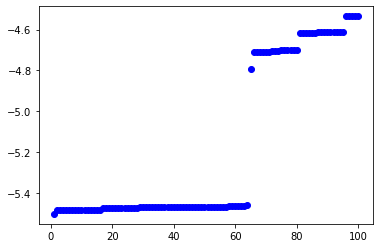

In [208]:
plt.clf()

E_p_temp = E_p[:100]

# add a `nan` value in front of the energy list
Y_p = np.array([np.nan] + list(E_p_temp))

pos_list = np.arange(Y_p.size)

# get the values in the list
Y_p_unique = np.unique(Y_p)

# loop over the unique value list
for E in Y_p_unique:
    if E is not np.nan:
        idE = (Y_p==E)
        plt.plot(pos_list[idE], Y_p[idE], marker='o', linestyle='-', color='b')
#         print(E)
#         print(Y_p == E)

Let's count the degeneracies!

In [235]:
def count_degeneracy(E_list):
    """
        Input a list for the energy and then it will automatically count the degeneracies
        return the unique energy list and the degeneracy dictionary
    """
    E_p_unique = np.unique(E_list)

    E_p_list = list(E_list)
    E_p_deg_dict = dict() # dict for the degeneracies
    for E in E_p_unique:
        E_p_deg_dict[E] = E_p_list.count(E)
        pass

    E_p_pos_dict = dict() # dict for the designed x positions
    for E in E_p_unique:
        degeneracy = E_p_deg_dict[E]
        if degeneracy==1:
            E_p_pos_dict[E] = [0]
        else:
            max_extent = np.arctan(degeneracy)
            E_p_pos_dict[E] = np.linspace(-max_extent, max_extent, degeneracy)
        pass
    
    return E_p_unique, E_p_pos_dict

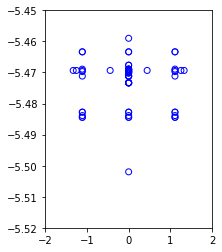

In [257]:
plt.figure(figsize=(3, 4))
for E in E_p_unique:
    x_list = E_p_pos_dict[E]
    plt.scatter(x_list, [E]*len(x_list), marker='o', c='', edgecolors='b')
    pass
plt.xlim(right=2, left=-2)
plt.ylim(top=-5.45, bottom=-5.52)
plt.savefig(f'Energy_PBC_Jx_{Jx}_Jy_{Jy}_Jz_{Jz}.png')
plt.show()

In [242]:
E_o_unique, E_o_pos_dict = count_degeneracy(E_o)

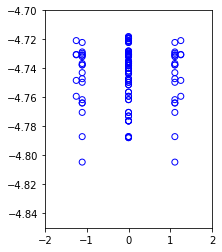

In [258]:
plt.figure(figsize=(3, 4))
for E in E_o_unique:
    x_list = E_o_pos_dict[E]
    plt.scatter(x_list, [E]*len(x_list), marker='o', c='', edgecolors='b')
#     plt.plot(np.linspace(x_list[0]-.1,x_list[-1]+.1,1000), [E]*1000, '-', color='b')
    pass
plt.xlim(right=2, left=-2)
plt.ylim(top=-4.7, bottom=-4.85)
plt.savefig(f'Energy_OBC_Jx_{Jx}_Jy_{Jy}_Jz_{Jz}.png')
plt.show()